# Assignment 4 Submitted by Sriramakrishna TURAGA (164010012)

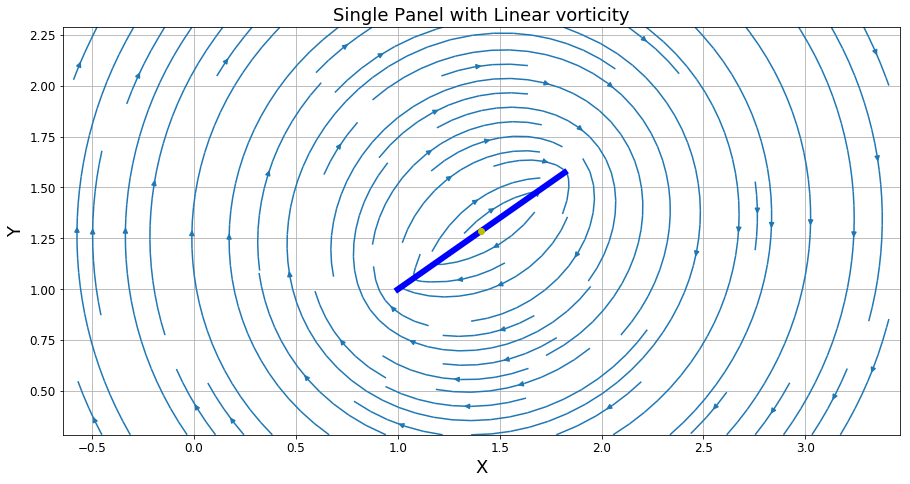

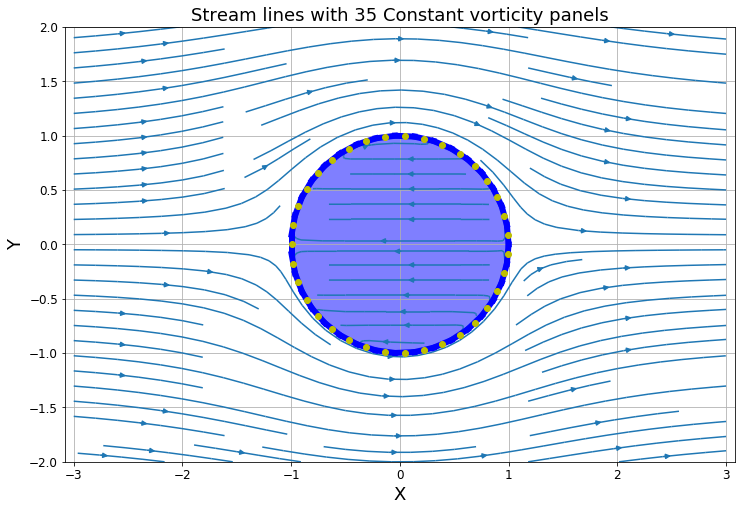

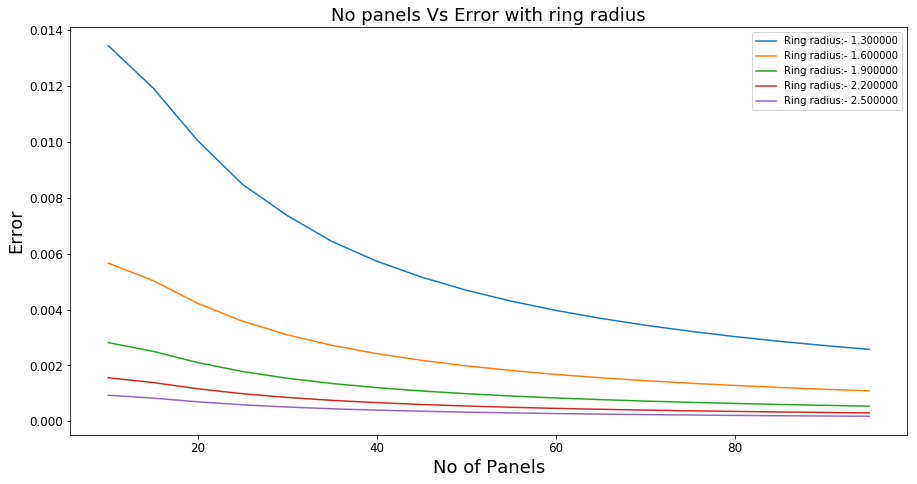

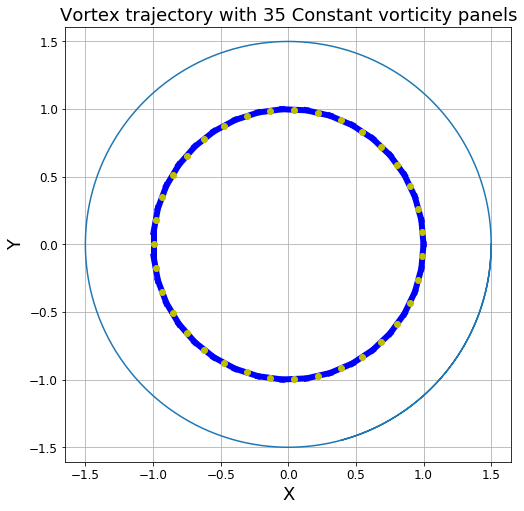

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
# plt.ion()

V=complex(0.0,0.0)

class Panel:
    def __init__(self,start,end,strength=0,pnl_type=0):
        self.start=start
        self.end=end
        self.l=np.abs(end-start)
        self.t=((self.end-self.start)/abs(self.end-self.start))
        self.contol_point=0.5*(self.start+self.end)
        self.strength=strength
        self.pnl_type=pnl_type
              
    def vortexpanel_coeff(self,field):
        if self.pnl_type==0:
            zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
            complex_coef=1j/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
            self.coeff=complex_coef.conjugate()
        else:
            self.coeff=[]
            zprime=(field-self.start)*self.t.conjugate()
            complex_coeff1=1j/(2*np.pi)*((zprime/self.l-1)*np.log((zprime-self.l)/zprime)+1.0)*self.t.conjugate()
            complex_coeff2=-1j/(2*np.pi)*((zprime/self.l)*np.log((zprime-self.l)/zprime)+1.0)*self.t.conjugate()
            self.coeff.append(complex_coeff1.conjugate())
            self.coeff.append(complex_coeff2.conjugate())
        return self.coeff
    
    def vortexpanel_vel(self,field,strength):
        if self.pnl_type==0:
            zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
            complex_vel=1j*strength/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
            self.complex_vel=complex_vel.conjugate()
        else:
#             print('yet to implement code')
            zprime=(field-self.start)*self.t.conjugate()
            complex_vel1=1j*strength[0]/(2*np.pi)*((zprime/self.l-1)*np.log((zprime-self.l)/zprime)+1.0)*self.t.conjugate()
            complex_vel2=-1j*strength[1]/(2*np.pi)*((zprime/self.l)*np.log((zprime-self.l)/zprime)+1.0)*self.t.conjugate()
            self.complex_vel=complex_vel1.conjugate()+complex_vel2.conjugate()
#             self.complex_vel.append(complex_vel2.conjugate())
 
        return self.complex_vel
    
    def panel_normal(self,origin):
        self.normal=(self.contol_point-origin)/np.abs(self.contol_point-origin)

    def draw(self):
        plt.plot([self.start.real,self.end.real],[self.start.imag,self.end.imag],linewidth=6,c='#0000ff')
        plt.plot(self.contol_point.real,self.contol_point.imag,'o',c='y')
        
        
def vortex_vel(z, vortex_pos, vortex_str):
    return (-1j*vortex_str/(2*np.pi*(z - vortex_pos))).conjugate()

def source_vel(z, source_pos, source_str):
    return (source_str*np.log(z - source_pos)).conjugate() 



def create_mesh(x_low = -2, x_up = 2,n_x = 100,y_low = -2, y_up = 2,n_y = 100 ):
    "create_mesh(x_low, x_up, n_x, y_low, y_up, n_y) \
    Leave empty to use the default values"
    x = np.linspace(x_low,x_up,n_x)
    y = np.linspace(y_low,y_up,n_y)
    X,Y = np.meshgrid(x,y)
    z = X+1j*Y
    return z

def single_panel(angle=0,pnl_type=0):
    plt.close('all')
    plt.figure(figsize=(15,7.5))

    if pnl_type==0:
        gamma=1.0
    else:
        gamma=[]
        gamma.append(1.0)
        gamma.append(1.5)
#     print(gamma[0])
    angles=np.linspace(0,180,11)
    start=complex(1.0,1.0)
    end=complex(start.real+np.cos(angle*np.pi/180),start.imag+np.sin(angle*np.pi/180))
    
    c=0.5*(start+end)

    z = create_mesh(x_low=c.real-2,x_up=c.real+2,n_x=100, y_low=c.imag-1,y_up=c.imag+1,n_y=100)

    P=Panel(start,end,pnl_type=pnl_type)
    P.vortexpanel_coeff(z)
    P.vortexpanel_vel(z,gamma)
#     print(len(P.coeff))
    P.draw()
    complex_vel = P.complex_vel+V#+freestream_phi(V,z) + 

    plt.streamplot(z.real,z.imag,complex_vel.real,complex_vel.imag)
    plt.axis('equal')
    plt.grid('on')
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
#     print(P.pnl_type)
    if P.pnl_type==0:
        title='Single Panel with Constant vorticity'
    else:
        title='Single Panel with Linear vorticity'
        
    plt.title(title,fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    

def complex_mult(a,b):
    return a.real*b.real+a.imag*b.imag

def assemble_coeff_mat(Ps):
    no_panels=len(Ps)
    cm=np.zeros([no_panels+1,no_panels],dtype=complex)
    for i in range(no_panels):
        for j in range(no_panels):
            if Ps[j].pnl_type==0:
                cm[i,j]=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point),Ps[i].normal)
            else:
                print
                if j==no_panels:
                    nextj=0
                else:
                    nextj=j+1
                coeff1=Ps[j].vortexpanel_coeff(Ps[i].contol_point)
                coeff2=Ps[nextj].vortexpanel_coeff(Ps[i].contol_point)
                cm[i,j]+=complex_mult(coeff1[0],Ps[i].normal)+complex_mult(coeff2[0],Ps[i].normal)
#     print(np.shape(cm))
    return cm

def assemble_b_mat(Ps,V, vortex_pos=[0.0+0.0j], vortex_str=[0.0+0.0j], source_pos=[0.0+0.0j], source_str=[0.0+0.0j]):
    no_panels=len(Ps)
    bm=np.zeros([no_panels+1,1],dtype=complex)
    for i in range(no_panels):
        v_source = 0.0 + 0.0j
        for j, z in enumerate(source_pos):
            v_source += source_vel(Ps[i].contol_point, z, source_str[j])
        v_vortex = 0.0 + 0.0j
        for j, z in enumerate(vortex_pos):
            v_vortex += vortex_vel(Ps[i].contol_point, z, vortex_str[j])
        
        V_final=V + v_source + v_vortex
        bm[i]=-complex_mult(V_final,Ps[i].normal)
        
#     print(np.shape(bm))
    return bm

def generate_panels(no_panels,radius,origin,pnl_type=0):
    radians = np.linspace(0,2*np.pi,no_panels+1) 
    points = origin + radius*(np.cos(radians) +1j*np.sin(radians))
    end = points[1:]
    start = points[:-1]

#     plt.figure(figsize=(15,7.5))
    Ps=[]
    for i in range(no_panels):
        Ps.append(Panel(start[i],end[i],pnl_type=pnl_type))
        Ps[i].panel_normal(origin)
#         Ps[i].draw()
    return Ps

def rk2_integrate(z,z_src,vort_gama,Vinf, dt ,tf,Ps,cm):
    result = [z]
    t = 0.0
    while t < tf:
        vel = get_velocity(Ps,Vinf,z,vort_gama,cm)
        k1 = vel*dt
        z += k1
        vel = get_velocity(Ps,Vinf,z,vort_gama,cm)
        k2 = vel*dt
        z += 0.5*(-k1 + k2) 
        result.append(z.copy()) 
        t += dt
#         print t,z
    return np.asarray(result)

def get_velocity(Ps,Vinf,vortex_pos,vortex_str,cm):
    bm=assemble_b_mat(Ps,Vinf,vortex_pos=vortex_pos,vortex_str=vortex_str).real
    bm[-1]=0.0
    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    Comple_vel=Vinf
    for i in range(len(Ps)):
        Ps[i].vortexpanel_vel(vortex_pos,gamma_mat[i])
        Comple_vel+=Ps[i].complex_vel
       
    return Comple_vel

def points_generate(num_points,pcr,center):
    radians = np.linspace(0,2*np.pi,num_points+1)[:-1] 
    points = center + pcr*(np.cos(radians) +1j*np.sin(radians))
    return points,radians
    
def exact_vel(points,radians,Vinf,cr,pcr):
    Vr=np.abs(Vinf)*(1-cr**2/pcr**2)*np.cos(radians)
    Vt=-np.abs(Vinf)*(1+cr**2/pcr**2)*np.sin(radians)
    Vexact=np.sqrt(Vr**2+Vt**2)
    return Vexact


def problem1(n,r):
    no_panels=n
    radius=r
    origin=complex(0,0)
    Vinf=complex(1.0,0)

    z = create_mesh(x_low=-2+origin.real-r,x_up=2+origin.real+r,n_x=100, y_low=-1+origin.imag-r,y_up=1+origin.imag+r,n_y=100)

    Ps=generate_panels(no_panels,radius,origin)

    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf).real

    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

#     gamma_mat=np.linalg.solve(cm,bm)
    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    # print(gamma_mat)

    Comple_vel=Vinf
    for i in range(no_panels):
        Ps[i].vortexpanel_vel(z,gamma_mat[i])
        Comple_vel+=Ps[i].complex_vel

    plt.figure(figsize=(12,8))    

    plt.streamplot(z.real,z.imag,Comple_vel.real,Comple_vel.imag)
    plt.axis('equal')
    for i in range(no_panels):
        Ps[i].draw()
    circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#0000ff', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Stream lines with %d Constant vorticity panels'%no_panels,fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()

        
def error_constant_vortex():
    plt.figure(figsize=(15,7.5))
    num_points=200
    n_panels=np.asarray(range(10,100,5))

    pcrs=np.linspace(1,2.5,6)[1:]
    for pcr in pcrs:
        error=[]
        for no_panels in n_panels:
            radius=1.0
            origin=complex(10,10)
            Vinf=complex(1.0,0)


            z,t = points_generate(num_points,pcr,origin)

            Ps=generate_panels(no_panels,radius,origin)

            cm=assemble_coeff_mat(Ps)
            bm=assemble_b_mat(Ps,Vinf).real

            for i in range(no_panels):
                cm[-1,i]=Ps[i].l
            bm[-1]=0

            gamma_mat=np.linalg.lstsq(cm,bm)[0]

            Comple_vel=Vinf
            for i in range(no_panels):
                Ps[i].vortexpanel_vel(z,gamma_mat[i])
                Comple_vel+=Ps[i].complex_vel

            points,radians=points_generate(num_points,pcr,complex(0,0))
            Vexact=exact_vel(points,radians,Vinf,radius,pcr)
            err=np.abs(Comple_vel)-Vexact
#             error.append(np.sqrt(sum(err**2)/num_points))

            error.append(sum(np.abs(Comple_vel)-Vexact)/num_points)

        plt.plot(n_panels,error,label='Ring radius:- %f'%pcr)        
    plt.xlabel('No of Panels',fontsize=18)
    plt.ylabel('Error',fontsize=18)
    plt.title('No panels Vs Error with ring radius',fontsize=18)
    plt.legend(loc=1,fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    return error,n_panels

def traj(no_panels,radius,dt,tf,origin=complex(0,0),Vinf=complex(0,0),
         vortex_pos=[0+0j], vortex_str=[0.0],source_pos=[0+0j],source_str=[0.0]):
      
#     t=0

    Ps=generate_panels(no_panels,radius,origin)
    plt.figure(figsize=(8,8))
    for i in range(no_panels):
        Ps[i].draw()


    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf,vortex_pos=vortex_pos,vortex_str=vortex_str).real
    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    
#     z=
    result=rk2_integrate(vortex_pos,vortex_pos,vortex_str,Vinf, dt ,tf,Ps,cm)
    plt.axis('equal')
    plt.plot(result.real,result.imag)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Vortex trajectory with %d Constant vorticity panels'%no_panels,fontsize=18)
#     plt.legend(loc=1,fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    
    return result


def method_of_images():
    ''' If we want to produce a stream lines of cylinder due to a=1.0 and a vortex located at b'''
    vortex_b_loc=complex(0,1.5)
    strength= 2*np.pi
    radius=1.0
    origin=complex(0,0)
    vortex_c_loc=complex(0,radius**2/np.abs(vortex_b_loc))
    vortex_a_loc=origin
    
    z= create_mesh(-3.0,3.0,100,-2,2,100)
    
# def source_vel(z, source_pos, source_str):
    Complex_vel=vortex_vel(z,vortex_b_loc,strength)+vortex_vel(z,vortex_c_loc,-strength)
    +vortex_vel(z,vortex_a_loc,strength)
    plt.figure(figsize=(15,7.5))
    plt.streamplot(z.real,z.imag,Complex_vel.real,Complex_vel.imag)
    circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#0000ff', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
#     plt.title('Stream lines with %d Constant vorticity panels'%no_panels,fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis('equal')
    plt.grid()
    

# plt.show()

if __name__ == '__main__':
    single_panel(angle=35,pnl_type=1)
    problem1(35,1.0)
    error,n_panels=error_constant_vortex()
    result=traj(35,1.0,0.05,20.0,vortex_pos=[1.5+0j],vortex_str=[2*np.pi])
#     method_of_images()
    plt.show()


In [4]:
def rk2_integrate1(z,z_src,strength,Vinf, dt ,tf,sv_flag):
    result = [z]
    t = 0.0
    while t < tf:
        vel = get_velo(z,z_src,strength,Vinf,sv_flag)
        k1 = vel*dt
        z += k1
        z_src=np.asarray([z,complex(0.0)])
        vel = get_velo(z,z_src,strength,Vinf,sv_flag)
        k2 = vel*dt
        z += 0.5*(-k1 + k2) 
        z_src=np.asarray([z,complex(0.0)])
                         
        result.append(z.copy()) 
        t += dt
        print t,z
    return np.asarray(result)


def method_of_images(dt,tf):
    ''' If we want to produce a stream lines of cylinder due to a=1.0 and a vortex located at b'''
    vortex_b_loc=complex(-1.5,0.0)
    strength= 2*np.pi
    radius=1.0
    origin=complex(0,0)
    vortex_c_loc=complex(-radius**2/np.abs(vortex_b_loc),0)
    vortex_a_loc=origin
    Vinf=complex(10.0,0.0)
    
    z= create_mesh(-3.0,3.0,100,-2,2,100)
    z_src=np.asarray([vortex_b_loc,vortex_c_loc,vortex_a_loc])
    zm=np.asarray([vortex_b_loc,vortex_c_loc])
    print z_src
    strength=np.asarray([2*np.pi,-2*np.pi,2*np.pi])
    
    result=rk2_integrate1(zm,z_src,strength,Vinf, dt ,tf,0)
    
    return result
    
      

def get_velo(z,z_src,strength,V,sv_flag):
    vel = np.zeros_like(z)
    if sv_flag:
        get_vel=source_vel
    else:
        get_vel=vortex_vel
    
    for i,z_i in enumerate(z):
        for j,z_j in enumerate(z_src):
            if z_i != z_j:
                vel[i] += get_vel(z_i,z_j,strength[j])              
    vel += V    
    return vel

res=method_of_images(0.05,20)

plt.plot(res[0].real,res[0].imag)
plt.show()
    

[-1.50000000+0.j -0.66666667+0.j  0.00000000+0.j]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# def source_vel(z, source_pos, source_str):
#     Complex_vel=vortex_vel(z,vortex_b_loc,strength)+vortex_vel(z,vortex_c_loc,-strength)
#     +vortex_vel(z,vortex_a_loc,strength)+Vinf*z
#     Complex_vel=get_velo(zm,z_src,strength,Vinf,0)

#     plt.figure(figsize=(15,7.5))
#     plt.axis('equal')
#     plt.streamplot(z.real,z.imag,Complex_vel.real,Complex_vel.imag)
#     circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#ff1100', alpha=0.35)
#     plt.gca().add_patch(circle)
#     plt.show()
    
#     return(complex_vel)


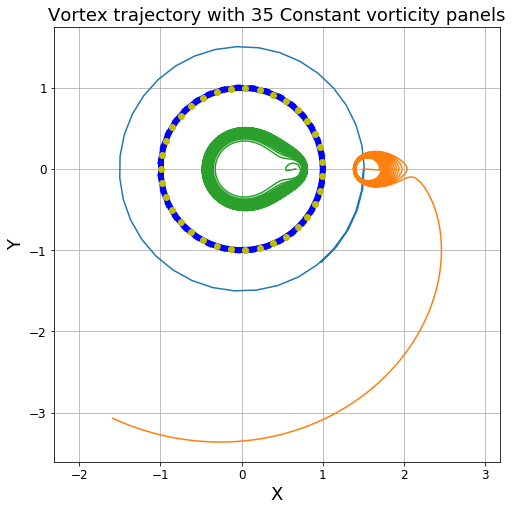

In [72]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
# plt.ion()

V=complex(0.0,0.0)

class Panel:
    def __init__(self,start,end,strength=0,pnl_type=0):
        self.start=start
        self.end=end
        self.l=np.abs(end-start)
        self.t=((self.end-self.start)/abs(self.end-self.start))
        self.contol_point=0.5*(self.start+self.end)
        self.strength=strength
        self.pnl_type=pnl_type
              
    def vortexpanel_coeff(self,field):
        if self.pnl_type==0:
            zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
            complex_coef=1j/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
            self.coeff=complex_coef.conjugate()
        else:
            self.coeff=[]
            zprime=(field-self.start)*self.t.conjugate()
            complex_coeff1=1j/(2*np.pi)*((zprime/self.l-1)*np.log((zprime-self.l)/zprime)+1.0)*self.t.conjugate()
            complex_coeff2=-1j/(2*np.pi)*((zprime/self.l)*np.log((zprime-self.l)/zprime)+1.0)*self.t.conjugate()
            self.coeff.append(complex_coeff1.conjugate())
            self.coeff.append(complex_coeff2.conjugate())
        return self.coeff
    
    def vortexpanel_vel(self,field,strength):
        if self.pnl_type==0:
            zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
            complex_vel=1j*strength/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
            self.complex_vel=complex_vel.conjugate()
        else:
#             print('yet to implement code')
            zprime=(field-self.start)*self.t.conjugate()
            complex_vel1=1j*strength[0]/(2*np.pi)*((zprime/self.l-1)*np.log((zprime-self.l)/zprime)+1.0)*self.t.conjugate()
            complex_vel2=-1j*strength[1]/(2*np.pi)*((zprime/self.l)*np.log((zprime-self.l)/zprime)+1.0)*self.t.conjugate()
            self.complex_vel=(complex_vel1+complex_vel2).conjugate()
#             self.complex_vel.append(complex_vel2.conjugate())
 
        return self.complex_vel
    
    def panel_normal(self,origin):
        self.normal=(self.contol_point-origin)/np.abs(self.contol_point-origin)

    def draw(self):
        plt.plot([self.start.real,self.end.real],[self.start.imag,self.end.imag],linewidth=6,c='#0000ff')
        plt.plot(self.contol_point.real,self.contol_point.imag,'o',c='y')
        
        
def vortex_vel(z, vortex_pos, vortex_str):
    return (-1j*vortex_str/(2*np.pi*(z - vortex_pos))).conjugate()

def source_vel(z, source_pos, source_str):
    return (source_str*np.log(z - source_pos)).conjugate() 



def create_mesh(x_low = -2, x_up = 2,n_x = 100,y_low = -2, y_up = 2,n_y = 100 ):
    "create_mesh(x_low, x_up, n_x, y_low, y_up, n_y) \
    Leave empty to use the default values"
    x = np.linspace(x_low,x_up,n_x)
    y = np.linspace(y_low,y_up,n_y)
    X,Y = np.meshgrid(x,y)
    z = X+1j*Y
    return z

def complex_mult(a,b):
    return a.real*b.real+a.imag*b.imag

def assemble_coeff_mat(Ps):
    no_panels=len(Ps)
    cm=np.zeros([no_panels+1,no_panels],dtype=complex)
    for i in range(no_panels):
        for j in range(no_panels):
            if Ps[j].pnl_type==0:
                cm[i,j]=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point),Ps[i].normal)
            else:
                cm[i,j]+=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point)[0],Ps[i].normal)
                if j<no_panels-1:
                    cm[i,j+1]+=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point)[1],Ps[i].normal)
                else:
                    cm[i,0]+=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point)[1],Ps[i].normal)
        #             print(i,j)
#     print(np.shape(cm))
    return cm

def assemble_b_mat(Ps,V, vortex_pos=[0.0+0.0j], vortex_str=[0.0+0.0j], source_pos=[0.0+0.0j], source_str=[0.0+0.0j]):
    no_panels=len(Ps)
    bm=np.zeros([no_panels+1,1],dtype=complex)
    for i in range(no_panels):
        v_source = 0.0 + 0.0j
        for j, z in enumerate(source_pos):
            v_source += source_vel(Ps[i].contol_point, z, source_str[j])
        v_vortex = 0.0 + 0.0j
        for j, z in enumerate(vortex_pos):
            v_vortex += vortex_vel(Ps[i].contol_point, z, vortex_str[j])
        
        V_final=V + v_source + v_vortex
        bm[i]=-complex_mult(V_final,Ps[i].normal)
        
#     print(np.shape(bm))
    return bm

def generate_panels(no_panels,radius,origin,pnl_type=0):
    radians = np.linspace(0,2*np.pi,no_panels+1) 
    points = origin + radius*(np.cos(radians) +1j*np.sin(radians))
    end = points[1:]
    start = points[:-1]

#     plt.figure(figsize=(15,7.5))
    Ps=[]
    for i in range(no_panels):
        Ps.append(Panel(start[i],end[i],pnl_type=pnl_type))
        Ps[i].panel_normal(origin)
#         Ps[i].draw()
    return Ps

def rk2_integrate(z,z_src,vort_gama,Vinf, dt ,tf,Ps,cm):
    result = [z]
    t = 0.0
    while t < tf:
        vel = get_velocity(Ps,Vinf,z,vort_gama,cm)
        k1 = vel*dt
        z += k1
        vel = get_velocity(Ps,Vinf,z,vort_gama,cm)
        k2 = vel*dt
        z += 0.5*(-k1 + k2) 
        result.append(z.copy()) 
        t += dt
#         print t,z
    return np.asarray(result)

def get_velocity(Ps,Vinf,vortex_pos,vortex_str,cm):
    bm=assemble_b_mat(Ps,Vinf,vortex_pos=vortex_pos,vortex_str=vortex_str).real
    bm[-1]=0.0
    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    Comple_vel=Vinf
    for i in range(len(Ps)):
        Ps[i].vortexpanel_vel(vortex_pos,gamma_mat[i])
        Comple_vel+=Ps[i].complex_vel
       
    return Comple_vel

def points_generate(num_points,pcr,center):
    radians = np.linspace(0,2*np.pi,num_points+1)[:-1] 
    points = center + pcr*(np.cos(radians) +1j*np.sin(radians))
    return points,radians
    
def exact_vel(points,radians,Vinf,cr,pcr):
    Vr=np.abs(Vinf)*(1-cr**2/pcr**2)*np.cos(radians)
    Vt=-np.abs(Vinf)*(1+cr**2/pcr**2)*np.sin(radians)
    Vexact=np.sqrt(Vr**2+Vt**2)
    return Vexact

def rk2_integrate1(z,z_src,strength,V, dt ,tf):
    result = [z]
    t = 0.0
    while t < tf:
        vel = get_vel(z, z_src, strength, V)
        k1 = vel*dt
        z += k1
        vel = get_vel(z, z_src, strength, V)
        k2 = vel*dt
        z += 0.5*(-k1 + k2) 
        result.append(z.copy())
        t += dt
    return np.asarray(result)

def get_vel(z,z_src,strength,V):
    vel = np.zeros_like(z)
    for i,z_i in enumerate(z):
#         print(z_i)
        for j,z_j in enumerate(z_src):
#             print(z_j)
            if z_i != z_j:
                vel[i] += vortex_vel(z_i,z_j,strength[j])              
    vel += V    
    return vel


########################################################################################################################
def single_panel(angle=0,pnl_type=0):
#     plt.close('all')
    plt.figure(figsize=(15,7.5))

    if pnl_type==0:
        gamma=1.0
    else:
        gamma=[]
        gamma.append(1)
        gamma.append(10)
#     print(gamma[0])
    angles=np.linspace(0,180,11)
    start=complex(0,0.0)
    end=complex(start.real+np.cos(angle*np.pi/180),start.imag+np.sin(angle*np.pi/180))
    
    c=0.5*(start+end)

    z = create_mesh(x_low=c.real-2,x_up=c.real+2,n_x=100, y_low=c.imag-1,y_up=c.imag+1,n_y=100)

    P=Panel(start,end,pnl_type=pnl_type)
    P.vortexpanel_coeff(z)
    P.vortexpanel_vel(z,gamma)
#     print(len(P.coeff))
    P.draw()
    complex_vel = P.complex_vel+V#+freestream_phi(V,z) + 

    plt.streamplot(z.real,z.imag,complex_vel.real,complex_vel.imag)
    plt.axis('equal')
    plt.grid('on')
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
#     print(P.pnl_type)
    if P.pnl_type==0:
        title='Single Panel with Constant vorticity'
    else:
        title='Single Panel with Linear vorticity'
        
    plt.title(title,fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
def problem1(n,r,pnl_type=0):
    no_panels=n
    radius=r
    origin=complex(0,0)
    Vinf=complex(1.0,0)

    z = create_mesh(x_low=-2+origin.real-r,x_up=2+origin.real+r,n_x=100, 
                    y_low=-1+origin.imag-r,y_up=1+origin.imag+r,n_y=100)

    Ps=generate_panels(no_panels,radius,origin,pnl_type=pnl_type)

    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf).real

    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

#     gamma_mat=np.linalg.solve(cm,bm)
    gamma_mat=np.linalg.lstsq(cm,bm)[0]
#     print(gamma_mat)
#         print stren

    Comple_vel=Vinf
    for i in range(no_panels):
        if Ps[i].pnl_type==0:
            Ps[i].vortexpanel_vel(z,gamma_mat[i].real)
            Comple_vel+=Ps[i].complex_vel
        else:
#             print(gamma_mat[i])
            stren=np.zeros([2])
            if i<no_panels-1:
                stren[0]+=gamma_mat[i].real
                stren[1]+=gamma_mat[i+1].real

            else:
                stren[0]+=gamma_mat[i].real
                stren[1]+=gamma_mat[0].real
                
            Ps[i].vortexpanel_vel(z,stren)
            Comple_vel+=Ps[i].complex_vel
            


    plt.figure(figsize=(15,7.5))    

    plt.streamplot(z.real,z.imag,Comple_vel.real,Comple_vel.imag)
    plt.axis('equal')
    for i in range(no_panels):
        Ps[i].draw()
    circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#0000ff', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    if pnl_type==0:
        title='Stream lines with %d Constant vorticity panels'%no_panels
    else:
        title='Stream lines with %d Linear vorticity panels'%no_panels
        
    plt.title(title,fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()


def point_ring_velocity(Vinf,num_points,pcr,origin,no_panels,radius,pnl_type):
    
    z,t = points_generate(num_points,pcr,origin)

    Ps=generate_panels(no_panels,radius,origin,pnl_type=pnl_type)

    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf).real

    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

    gamma_mat=np.linalg.lstsq(cm,bm)[0]

    Comple_vel=Vinf
    for i in range(no_panels):
        if Ps[i].pnl_type==0:
            Ps[i].vortexpanel_vel(z,gamma_mat[i].real)
            Comple_vel+=Ps[i].complex_vel
        else:
#             print(gamma_mat[i])
            stren=np.zeros([2])
            if i<no_panels-1:
                stren[0]+=gamma_mat[i].real
                stren[1]+=gamma_mat[i+1].real

            else:
                stren[0]+=gamma_mat[i].real
                stren[1]+=gamma_mat[0].real
                
            Ps[i].vortexpanel_vel(z,stren)
            Comple_vel+=Ps[i].complex_vel
        
    return Comple_vel

        
def ring_velocity_error():
    fig1=plt.figure(figsize=(15,7.5))
    ax1=fig1.add_subplot(1,1,1)
    fig2=plt.figure(figsize=(15,7.5))
    ax2=fig2.add_subplot(1,1,1)
    num_points=200
    n_panels=np.asarray(range(10,100,5))

    pcrs=np.linspace(1,2.0,6)[1:]
    for pcr in pcrs:
        error_const=[]
        error_linear=[]
        for no_panels in n_panels:
            radius=1.0
            origin=complex(10,10)
            Vinf=complex(1.0,0)

            Comple_vel_const= point_ring_velocity(Vinf,num_points,pcr,origin,no_panels,radius,0)
            Comple_vel_linear= point_ring_velocity(Vinf,num_points,pcr,origin,no_panels,radius,1)


            points,radians=points_generate(num_points,pcr,complex(0,0))
            Vexact=exact_vel(points,radians,Vinf,radius,pcr)
            err1=np.abs(Comple_vel_const)-Vexact
            err2=np.abs(Comple_vel_linear)-Vexact
#             error_const.append(np.sqrt(sum(err1**2)/num_points))
#             error_linear.append(np.sqrt(sum(err2**2)/num_points))

            error_const.append(sum(abs(err1))/num_points)
            error_linear.append(sum(abs(err2))/num_points)
          
        ax1.plot(n_panels,error_const,label='Constant panel, Ring radius:- %f'%pcr)
        ax2.plot(n_panels,error_linear,label='Constant panel, Ring radius:- %f'%pcr)
    ax1.set_xlabel('No of Panels',fontsize=18)
    ax1.set_ylabel('Error',fontsize=18)
    ax2.set_xlabel('No of Panels',fontsize=18)
    ax2.set_ylabel('Error',fontsize=18)
    ax1.legend()
    ax2.legend()
    
    ax1.set_title('No panels Vs Error with ring radius Constant panel',fontsize=18)
    ax2.set_title('No panels Vs Error with ring radius Linear panel',fontsize=18)
#     plt.legend(loc=1,fontsize=10)
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)

    return error_const,error_linear,n_panels

def traj(no_panels,radius,dt,tf,origin=complex(0,0),Vinf=complex(0,0),
         vortex_pos=[0+0j], vortex_str=[0.0],source_pos=[0+0j],source_str=[0.0]):
      
#     t=0

    Ps=generate_panels(no_panels,radius,origin)
    plt.figure(figsize=(8,8))
    for i in range(no_panels):
        Ps[i].draw()


    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf,vortex_pos=vortex_pos,vortex_str=vortex_str).real
    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

    gamma_mat=np.linalg.lstsq(cm,bm)[0]
    
#     z=
    result=rk2_integrate(vortex_pos,vortex_pos,vortex_str,Vinf, dt ,tf,Ps,cm)
    plt.axis('equal')
    plt.plot(result.real,result.imag)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
    plt.title('Vortex trajectory with %d Constant vorticity panels'%no_panels,fontsize=18)
#     plt.legend(loc=1,fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    
    return result


def images(dt,tf):
    z=[complex(1.5,0.0),complex(1/1.5,0.0)]
    z_src=[complex(1.5,0.0),complex(1/1.5,0.0),complex(0,0)]
    V=complex(0,0)
    strength=[2*np.pi,-2*np.pi,-4*np.pi]
    result=rk2_integrate1(z,z_src,strength,V, dt ,tf)
    plt.plot(result.real,result.imag)
    
    

def method_of_images():
    ''' If we want to produce a stream lines of cylinder due to a=1.0 and a vortex located at b'''
    vortex_b_loc=complex(0,1.5)
    strength= 2*np.pi
    radius=1.0
    origin=complex(0,0)
    vortex_c_loc=complex(0,radius**2/np.abs(vortex_b_loc))
    vortex_a_loc=origin
    
    z= create_mesh(-3.0,3.0,100,-2,2,100)
    
# def source_vel(z, source_pos, source_str):
    Complex_vel=vortex_vel(z,vortex_b_loc,strength)+vortex_vel(z,vortex_c_loc,-strength)
    +vortex_vel(z,vortex_a_loc,strength)
    plt.figure(figsize=(15,7.5))
    plt.streamplot(z.real,z.imag,Complex_vel.real,Complex_vel.imag)
    circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#0000ff', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.xlabel('X',fontsize=18)
    plt.ylabel('Y',fontsize=18)
#     plt.title('Stream lines with %d Constant vorticity panels'%no_panels,fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis('equal')
    plt.grid()
    
    return Complex_vel
    
    

# plt.show()

if __name__ == '__main__':

#     single_panel(angle=35,pnl_type=0)
#     single_panel(angle=35,pnl_type=1)
    
#     problem1(12,1.0)
#     problem1(12,1.0,pnl_type=1)

#     error_const,error_linear,n_panels=ring_velocity_error()
    result=traj(35,1.0,0.5,20.0,vortex_pos=[1.5+0j],vortex_str=[2*np.pi])
    images(0.005,20)
#     method_of_images()
    plt.show()


In [45]:
x=np.linspace(0,10,25)
y1=x*np.random.rand()**2
y2=x*np.random.rand()**2
y3=x*np.random.rand()**2
y4=x*np.random.rand()**2
# plt.close('all')

fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1)
fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)
ax1.plot(x,y1)
ax2.plot(x,y2)
ax1.plot(x,y3)
ax2.plot(x,y4)
ax1.legend(['y1','y3'])
ax1.set_xlabel('X',fontsize=16)
ax1.set_xticklabels([:],fontsize=12)
# ax1.plot(x,y1)
# ax2.plot(x,y2)
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-45-85a79772c56d>, line 18)

In [ ]:
class Vortices:
    def __init__(self, gamma, pos):
        self.gamma = gamma
        self.pos = pos
        
    def set_state(self, state):
        self.pos = state
        return state

    def get_state(self):
        return self.pos
